<a href="https://colab.research.google.com/github/eissana/transformer/blob/master/shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"running on: {device}")

running on: cuda


# Read Data

In [2]:
with urlopen('https://raw.githubusercontent.com/eissana/transformer/master/data/shakespeare.txt') as f:
    words = f.read().decode('utf-8')
print(f'First few lines:\n {words[:200]}')

First few lines:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
print(f'Number of characters: {len(words)}')

Number of characters: 1115394


In [4]:
chars = sorted(set(words))
nchars = len(chars)
# includes \n (new line), space, numbers and letters.
print(f'{nchars = }')
','.join(chars)

nchars = 65


"\n, ,!,$,&,',,,-,.,3,:,;,?,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z"

In [5]:
atoi = {c: i for i, c in enumerate(chars)}
itoa = {i: c for i, c in enumerate(chars)}

In [6]:
def encode(str):
    return [atoi[c] for c in str]

def decode(arr):
    return ''.join([itoa[i] for i in arr])

str = words[:104]
enc = encode(str)
print(enc)
print(decode(enc))

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59, 1, 39, 56, 43]
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are


In [7]:
encdata = torch.tensor(encode(words), dtype=torch.long)
print(encdata[:104])

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43])


In [8]:
nencdata = len(encdata)
ntrain, nvalid = int(0.8*nencdata), int(0.1*nencdata)

data = {'train': encdata[:ntrain],
        'valid': encdata[ntrain:ntrain+nvalid],
        'test': encdata[ntrain+nvalid:]}

print('Data split: ', end='')
print(f"{nencdata} = {len(data['train'])} + {len(data['valid'])} + {len(data['test'])}")

Data split: 1115394 = 892315 + 111539 + 111540


# Model Parameters

In [33]:
nembd = 384
nhead = 6
nblock = 6
dropout = 0.3

nbatch = 64
block_size = 256

nepoch = 5000
eval_size = 500
lr = 3e-4

model_filename = 'multihead_transformer.pt'
final_losses = 'final_losses.txt'

# Utility Functions

In [10]:
def get_batch(data, nbatch, block_size):
    '''
    Generates a batch of examples.
    (x[i], y[i]) is a pair of consecutive characters in the text.
    '''
    indices = torch.randint(len(data)-block_size, (nbatch,))
    x = torch.stack([data[i:i+block_size] for i in indices]).to(device)
    y = torch.stack([data[i+1:i+block_size+1] for i in indices]).to(device)
    return x, y

In [11]:
x, y = get_batch(data['train'], nbatch=2, block_size=8)
x, y

(tensor([[58, 46, 47, 57,  1, 41, 47, 58],
         [54, 56, 39, 47, 57, 43, 57,  1]], device='cuda:0'),
 tensor([[46, 47, 57,  1, 41, 47, 58, 63],
         [56, 39, 47, 57, 43, 57,  1, 39]], device='cuda:0'))

In [12]:
def get_loss(logits, y):
    '''
    Computes cross-entropy loss, given logits and labels.
    '''
    B, T, C = logits.shape
    # F.cross_entropy expects size C, (B, C), or (B, C, ...)
    # logits shape is (B, T, C), so we flatten the first two dimensions.
    return F.cross_entropy(logits.view(B*T, C), y.view(B*T))

In [13]:
def train(model, data, nepoch=100, nbatch=20, block_size=8, lr=1e-3, losses=None):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    if losses is None:
        losses = {
            'train': [],
            'valid': [],
        }
    for _ in range(nepoch):
        x, y = get_batch(data['train'], nbatch=nbatch, block_size=block_size)

        logits = model(x)
        loss = get_loss(logits, y)
        losses['train'].append(loss.item())

        with torch.no_grad():
            x, y = get_batch(data['valid'], nbatch=nbatch, block_size=block_size)
            logits = model(x)
            vloss = get_loss(logits, y)
            losses['valid'].append(vloss.item())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return losses

In [14]:
def gen_text(model, block_size, max_size=100):
    '''
    Generates text using the model starting from nothing.
    '''
    # starting from '\n' char we generate text.
    x = torch.zeros((1, 1), dtype=torch.long, device=device)
    for _ in range(max_size):
        logits = model(x[:, -block_size:])
        # only consider the last logit
        logits = logits[:, -1, :]
        score = F.softmax(logits, dim=1)
        next_token = score.multinomial(1)
        x = torch.cat((x, next_token), dim=1)
    return x[0].tolist()

In [15]:
def nparameters(model):
    '''
    Returns the total number of model parameters.
    '''
    return sum([p.nelement() for p in model.parameters()])

# Multi-Head Transformer Model

In [16]:
class Head(nn.Module):
    '''
    Self-attention head layer.
    '''
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(nembd, head_size, bias=False)
        self.key = nn.Linear(nembd, head_size, bias=False)
        self.value = nn.Linear(nembd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        # tril is not a model parameter so we register it as a buffer.
        # block_size is the maximum size. The actual size can be smaller.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        _, T, C = x.shape
        query = self.query(x)
        key = self.key(x)
        weights = query @ key.transpose(-2, -1) * C**-0.5

        # The time dimension can be smaller than the block-size.
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)

        value = self.value(x)
        out = weights @ value

        return out

In [17]:
class MultiHead(nn.Module):
    def __init__(self, nhead, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(nhead)])
        self.proj = nn.Linear(nembd, nembd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [18]:
class FeedForward(nn.Module):
    def __init__(self, fain_in, fan_out):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(fain_in, 4 * fan_out),
            nn.ReLU(),
            nn.Linear(4 * fan_out, fan_out),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        out = self.ff(x)
        return out

In [19]:
class Block(nn.Module):
    def __init__(self, nembd, nhead):
        super().__init__()
        # self-attention heads
        self.sa = MultiHead(nhead, nembd//nhead)
        self.sa_layer_norm = nn.LayerNorm(nembd)
        # feed-forward network
        self.ff = FeedForward(nembd, nembd)
        self.ff_layer_norm = nn.LayerNorm(nembd)


    def forward(self, x):
        out = x
        # deep residual network
        out = out + self.sa(self.sa_layer_norm(out))
        out = out + self.ff(self.ff_layer_norm(out))
        return out

In [20]:
class Transformer(nn.Module):
    '''
    A simple transformer model for building a character-level
    language model using multiple self-attention heads.
    '''
    def __init__(self, nhead, nblock):
        super().__init__()
        self.token_emb = nn.Embedding(nchars, nembd)
        self.position_emb = nn.Embedding(block_size, nembd)
        self.blocks = nn.Sequential(*[Block(nembd, nhead) for _ in range(nblock)])
        self.layer_norm = nn.LayerNorm(nembd)
        self.linear = nn.Linear(nembd, nchars)

    def forward(self, x):
        _, T = x.shape
        # x.shape == (nbatch, block_size, nchars)
        # token_emb.shape == (nbatch, block_size, nembd)
        token_emb = self.token_emb(x)
        # position_emb.shape == (nbatch, block_size, nembd)
        position_emb = self.position_emb(torch.arange(T, device=device))
        # out.shape == (nbatch, block_size, nembd)
        out = token_emb + position_emb
        # out.shape == (nbatch, block_size, nembd)
        out = self.blocks(out)
        out = self.layer_norm(out)
        # out.shape == (nbatch, block_size, nchars)
        out = self.linear(out)

        return out

multihead_transformer = Transformer(nhead, nblock).to(device)

In [21]:
nparameters(multihead_transformer)

10788929

In [22]:
multihead_losses = None

In [34]:
multihead_losses = train(multihead_transformer, data, nepoch, nbatch, block_size, lr=lr, losses=multihead_losses)

In [35]:
print(f"final training loss: {np.mean(multihead_losses['train'][-eval_size:])}")
print(f"final validation loss: {np.mean(multihead_losses['valid'][-eval_size:])}")

final training loss: 1.0500414443016053
final validation loss: 1.5510670857429505


In [ ]:
torch.save(multihead_transformer, model_filename)

with open(final_losses, 'w') as f:
  f.write(f"final training loss: {np.mean(multihead_losses['train'][-eval_size:])}\n")
  f.write(f"final validation loss: {np.mean(multihead_losses['valid'][-eval_size:])}\n")

In [36]:
!cat $final_losses

final training loss: 1.2426115448474884
final validation loss: 1.4974986774921417


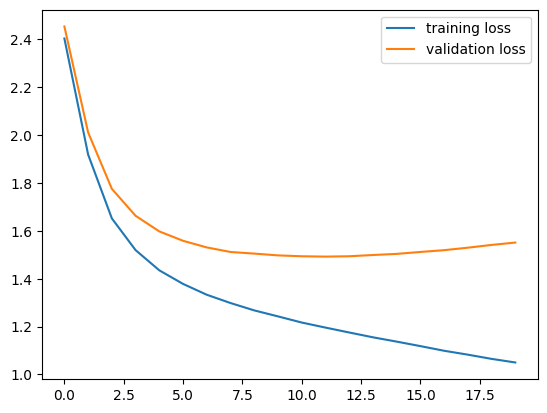

In [37]:
plt.plot(torch.tensor(multihead_losses['train']).view(-1, eval_size).mean(axis=1));
plt.plot(torch.tensor(multihead_losses['valid']).view(-1, eval_size).mean(axis=1));
plt.legend(['training loss', 'validation loss']);

In [29]:
multihead_transformer = torch.load(model_filename)

In [30]:
print(decode(gen_text(multihead_transformer, block_size, max_size=1000)))


bleed so but with Montague with the Champio;
And make my cuntrice a right braced where
As they victory, as magifore services from herbance,
Only subjects and men are counsely do in's bone,
That you, stands us shall not with the list
What you tell-when here? Loadest men; but do me kill;
For hand theirs are most unbanish'd away,
To spiciling on their furthes fairs
To lamb the tribunes from carries.
The Crowings thirty brought title, honestly rehevends,
That was like a fasherd shiftly please? would be
Like to exame from the friend; at the lay
As if they be mercise with yoursues?

MAMILIUS:
Oupon thy closemblet,
As I cannot came to worldam, the courteous daughter.

VIRG RICIO:
Nay, farewell, by my lord, or any haunt.

RATER:
Onle Peter! why do you would say you with subject,
Your heart Rome dead, you shall none do ask;
For you, Juliet a may God been;
The shadowes yourself of your deads,
To make us to fill be departeed
Scarcel you.

KING RICHARD II:

Post need of Clarence, Grey George!

KI